# Training model
___

This notebook demonstrates the complete workflow for training and evaluating a binary classification model using PyTorch and scikit-learn. The steps include:

- Importing necessary libraries and utility functions.
- Loading and exploring the dataset.
- Preparing and standardizing the data for model training.
- Creating PyTorch tensors and DataLoaders for efficient batching.
- Configuring and training a simple linear model using stochastic gradient descent.
- Visualizing training losses and evaluating model performance with confusion matrices and ROC curves.
- Calculating and analyzing key metrics such as precision, recall, F1-score, and ROC AUC at various thresholds.
- Saving results and providing a detailed classification report.

## Load libraries

In [1]:
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn

from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from sklearn.preprocessing import StandardScaler

sys.path.append('../')
from utils.architecture import Architecture
from utils.read_data import get_train_data, get_test_data
from utils.figures import *
from utils.metrics import get_metrics

In [2]:
SEED: int = 8
BATCH_SIZE: int = 32

In [3]:
torch.manual_seed(SEED)

## Reading data

In [4]:
df_full_train, df_full_test = get_train_data(), get_test_data()
print(f"Full train set size: {df_full_train.shape}")
print(f"Full test set size: {df_full_test.shape}")

Full train set size: (227845, 30)
Full test set size: (56962, 30)


In [5]:
df_full_test.shape[0] / (df_full_train.shape[0] + df_full_test.shape[0])

0.20000210668979343

In [6]:
df_train, df_val = df_full_train, df_full_test #train_test_split(df_full_train, test_size=0.2, random_state=SEED)
print(f"Train set size: {df_train.shape}")
print(f"Validation set size: {df_val.shape}")

Train set size: (227845, 30)
Validation set size: (56962, 30)


## Data preparation

In [7]:
df_train.columns

Index(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21',
       'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount', 'class'],
      dtype='object')

In [8]:
X_train = df_train.drop(columns=['class']).values
y_train = df_train['class'].values
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (227845, 29)
y_train shape: (227845,)


In [9]:
X_val = df_val.drop(columns=['class']).values
y_val = df_val['class'].values
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_val shape: (56962, 29)
y_val shape: (56962,)


### Data standardization

In [10]:
sc = StandardScaler()

In [11]:
sc.fit(X_train)

StandardScaler()

In [12]:
X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

### Create tensors

In [13]:
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

In [14]:
x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

### Create a DataLoader for each set

In [15]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

In [16]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [17]:
val_dataset = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## Model configuration

In [ ]:
learning_rate = 0.01
num_epochs = 200

In [19]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(X_train.shape[1], 1))

optmizer = optim.SGD(model.parameters(), lr=learning_rate)

los_fn = nn.BCEWithLogitsLoss()

IF i use sigmoid activation, I need to use BCE loss

IF i use no activation, I need to use BCEWithLogitsLoss, because it combines a Sigmoid layer and the BCELoss in one single class.

In [20]:
print(type(model))
print(model.state_dict())

<class 'torch.nn.modules.container.Sequential'>
OrderedDict({'linear.weight': tensor([[ 0.0364,  0.1282,  0.1658, -0.0756,  0.0051,  0.0536,  0.1482, -0.1805,
          0.0291, -0.1405,  0.1553,  0.0670, -0.1114, -0.1441, -0.1850,  0.1459,
          0.1132, -0.0911, -0.0118, -0.1232, -0.1221,  0.0038, -0.1460,  0.0339,
          0.1074, -0.1540, -0.0491, -0.0089,  0.0515]]), 'linear.bias': tensor([-0.0193])})


## Training

In [21]:
arch = Architecture(model=model, optimizer=optmizer, loss_fn=los_fn)

In [22]:
arch.set_loaders(train_loader=train_loader, val_loader=val_dataset)

In [23]:
arch.set_seed(SEED)
arch.train(n_epochs=num_epochs)

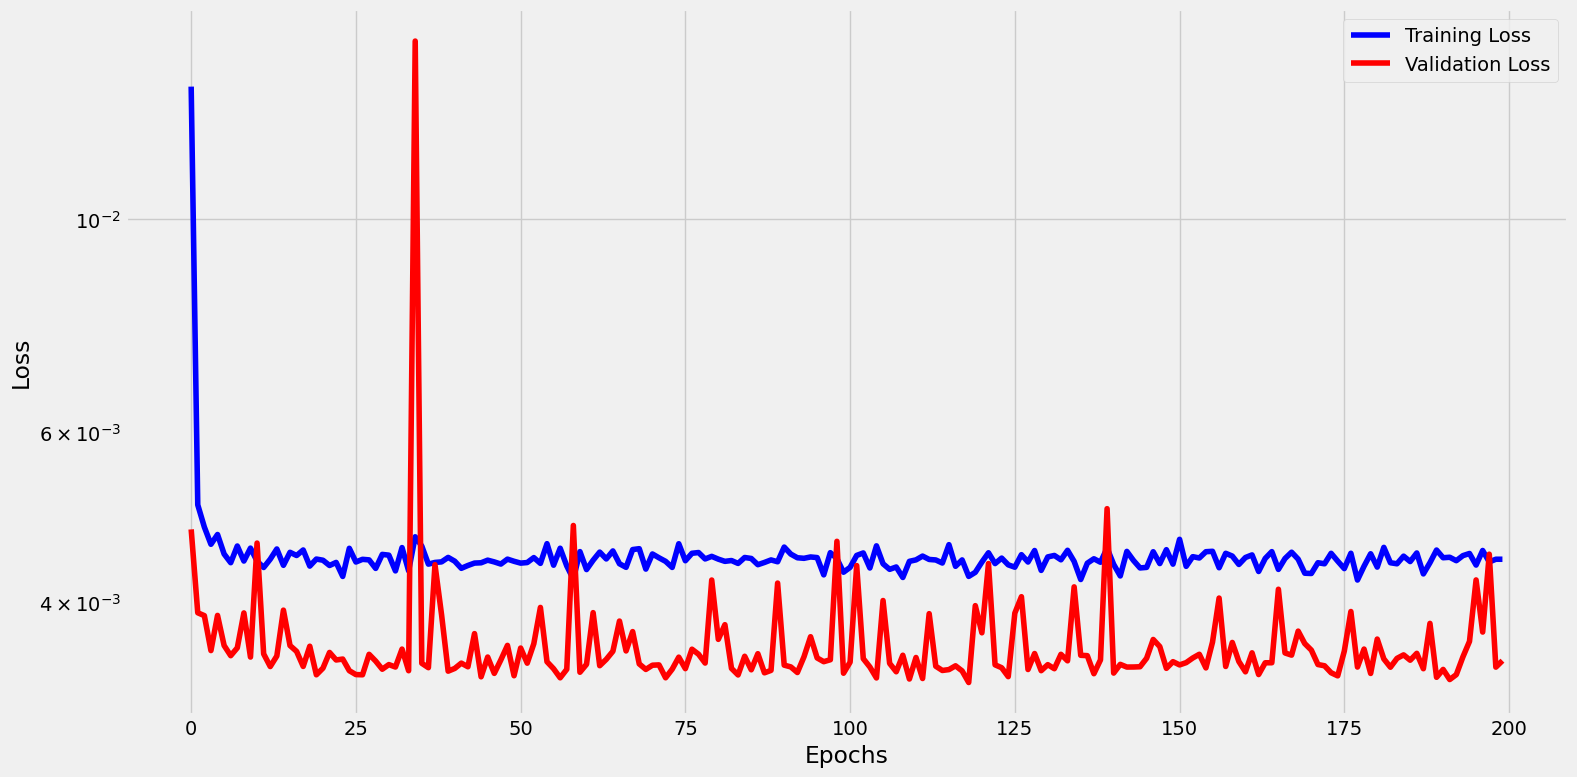

In [24]:
fig = arch.plot_losses()

In [25]:
arch.save_checkpoint(f'../model/model_checkpoint_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')

In [26]:
fig.savefig('images/train_losses.png', dpi=300, bbox_inches='tight')

In [27]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.2131, -0.0308,  0.0173,  0.9773,  0.0555, -0.0982, -0.0054, -0.1808,
                       -0.3785, -0.9547, -0.0905,  0.1541, -0.3621, -0.5251, -0.0879, -0.2323,
                       -0.0057, -0.0017,  0.0755, -0.3333,  0.2662,  0.3680, -0.0150,  0.0948,
                       -0.0334,  0.0182, -0.2087, -0.1058,  0.0976]], device='cuda:0')),
             ('linear.bias', tensor([-8.6909], device='cuda:0'))])

## Making predictions

### logits (z)

In [28]:
logits_val = arch.predict(X_val[:4])
logits_val

array([[ -8.368421 ],
       [ -7.1261954],
       [-11.647148 ],
       [ -9.3483   ]], dtype=float32)

### Probabilities

In [29]:
prob_val = torch.sigmoid(torch.as_tensor(logits_val[:4]).float())
prob_val

tensor([[2.3203e-04],
        [8.0313e-04],
        [8.7439e-06],
        [8.7106e-05]])

In [30]:
classes = (prob_val >= 0.5).to(torch.int8)
classes

tensor([[0],
        [0],
        [0],
        [0]], dtype=torch.int8)

## Results

In [31]:
logits_val = arch.predict(X_val)
probabilities_val = list(map(lambda x: torch.sigmoid(torch.as_tensor(x).float()), logits_val))
threshold = 0.5

### Data visualization

Confusion Matrix:
[[56856     5]
 [   38    63]]


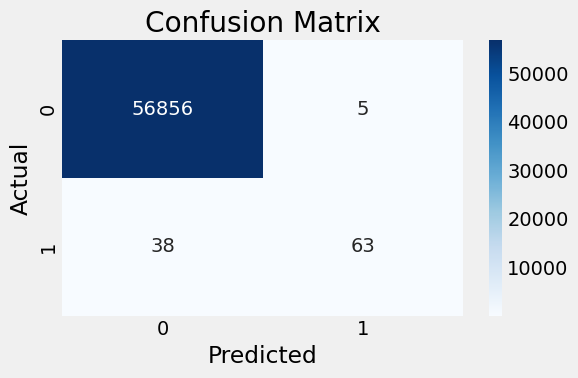

In [32]:
y_pred = (torch.stack(probabilities_val).numpy() >= threshold).astype(int)

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

fig_cm, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.tight_layout()

plt.savefig('images/train_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

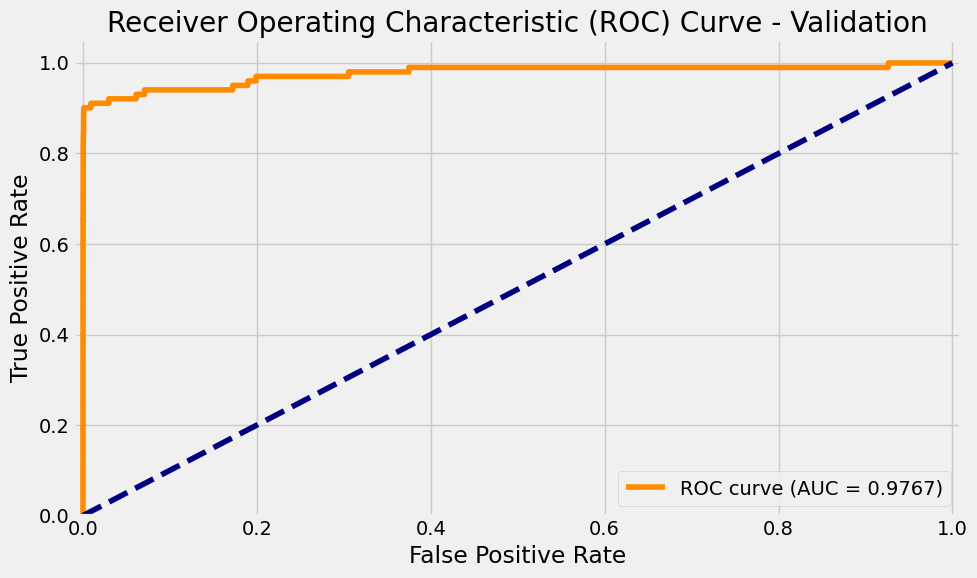

In [33]:
fpr, tpr, thresholds = roc_curve(y_val, [p.item() for p in probabilities_val])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation')
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig('images/train_val_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

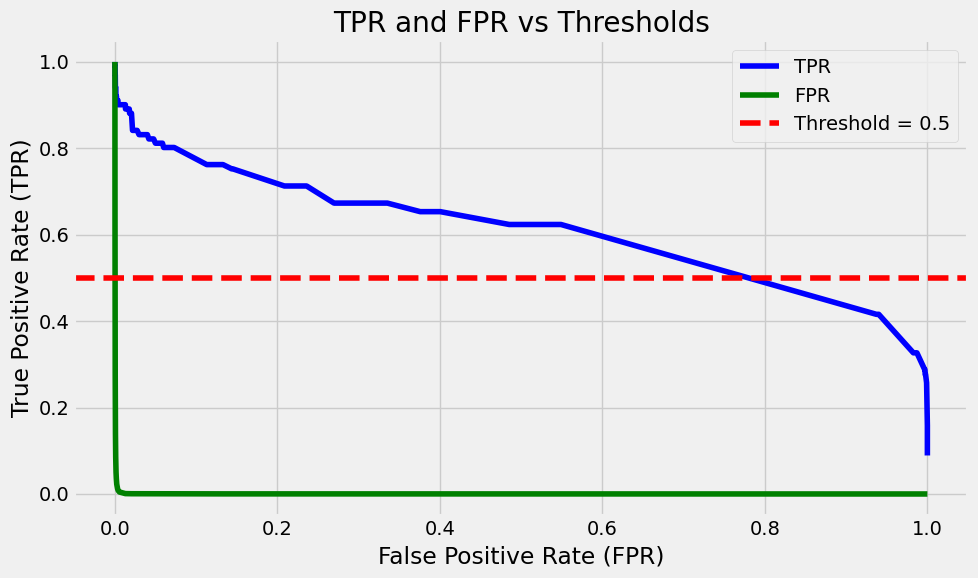

In [34]:
roc_auc = round(auc(fpr, tpr), 3)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='TPR', color='blue')
plt.plot(thresholds, fpr, label='FPR', color='green')
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold = 0.5')
# plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TPR and FPR vs Thresholds')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('images/train_tpr_fpr_vs_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
rounded_thresholds = [round(value, 3) for value in set(thresholds)]
print("Rounded Thresholds: ", len(rounded_thresholds))

Rounded Thresholds:  1493


In [36]:
results = []
for threshold in rounded_thresholds:
    y_val_pred = (probabilities_val >= threshold).astype(int)
    
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    results.append((threshold, precision, recall, f1))

# Convertir lista a DataFrame
metrics_df = pd.DataFrame(results, columns=['threshold', 'precision', 'recall', 'f1-score'])
metrics_df.sort_values(by="f1-score", ascending=False, inplace=True)
print(metrics_df)

      threshold  precision    recall  f1-score
35        0.050   0.836735  0.811881  0.824121
36        0.048   0.828283  0.811881  0.820000
19        0.059   0.835052  0.801980  0.818182
1007      0.060   0.835052  0.801980  0.818182
41        0.073   0.842105  0.792079  0.816327
...         ...        ...       ...       ...
1467      0.000   0.001773  1.000000  0.003540
1465      0.000   0.001773  1.000000  0.003540
1464      0.000   0.001773  1.000000  0.003540
1463      0.000   0.001773  1.000000  0.003540
523         inf   0.000000  0.000000  0.000000

[1493 rows x 4 columns]


In [37]:
best_threshold = metrics_df.iloc[0]["threshold"]
print(f'A threshold of {best_threshold} seems to be the best one for this model')

A threshold of 0.05 seems to be the best one for this model


In [38]:
metrics_df.to_csv('images/train_metrics_per_threshold.csv', index=False)

### Metrics

In [39]:
y_pred = (torch.stack(probabilities_val).numpy() >= best_threshold).astype(int)
val_roc_auc = round(roc_auc_score(y_val, y_pred),4)
print(f'The ROC AUC for the linear model is {val_roc_auc} on the validation dataset.')

The ROC AUC for the linear model is 0.9058 on the validation dataset.


In [49]:
y_train_pred_proba = arch.predict(X_train)
y_train_pred_proba = list(map(lambda x: torch.sigmoid(torch.as_tensor(x).float()), y_train_pred_proba))
y_train_pred_proba = (y_train_pred_proba >= best_threshold).astype(int)
train_roc_auc= round(roc_auc_score(y_train, y_train_pred_proba),4)
print(f'The ROC AUC for the linear model is {train_roc_auc} on the train dataset.')

The ROC AUC for the linear model is 0.9 on the train dataset.


In [50]:
get_metrics(model, y_val, y_pred, y_train, y_train_pred_proba, best_threshold)

Classification Report on validation set:
F1 Score on validation set: 0.8241
F1 Score on train set: 0.7757
Precision on validation set: 0.8367
Recall on validation set: 0.8119
Precision on train set: 0.7524
Recall on train set: 0.8005
ROC AUC on validation set: 0.9058
ROC AUC on train set: 0.9000
Best threshold: 0.0500
Number of trainable parameters: 30


In [51]:
print(classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56861
     Class 1       0.84      0.81      0.82       101

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



Confusion Matrix:
[[56845    16]
 [   19    82]]


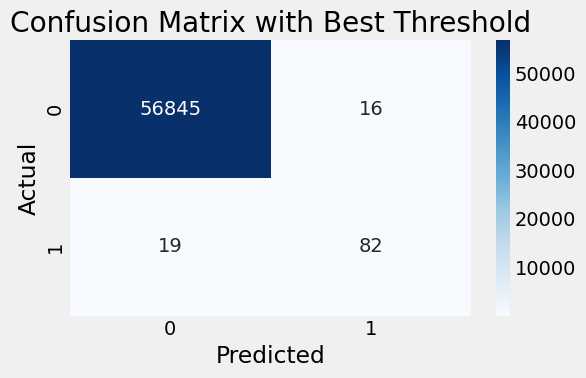

In [53]:
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

fig_cm, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix with Best Threshold')
plt.tight_layout()

plt.savefig('images/train_confusion_matrix_best_threshold.png', dpi=300, bbox_inches='tight')
plt.show()